## LSTM_tensorflow_tutorial [link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
import math
from scipy import stats

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
### Set fixed variables
MAX_EPOCHS = 20
### input files path
input_files = 'data/PROCESSED/STATIONS_CLEAN'
### output path
path = 'data/PROCESSED/MODEL_OUTPUTS'
## station name
station = 'guadalupe'
## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60 - 12
#30 - 6
#15 - 3
#5 - 1

In [3]:
df = pd.read_csv(f'{input_files}/{station}_validation.csv')

In [4]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-01-11 00:00:00,13.77,15.02,14.94,93.47,92.75,93.31,0.0,250.39,0.95,-0.318835,-0.894899,-0.961311,-0.446634,-0.321348,0.315017,-8.709422e-12,1.000000,0.180875,0.983506
1,2013-01-11 00:05:00,13.70,15.02,14.94,93.19,92.75,93.31,0.0,234.54,0.22,-0.127630,-0.179195,-0.961311,-0.446634,-0.321348,0.315017,2.181489e-02,0.999762,0.180934,0.983495
2,2013-01-11 00:10:00,13.74,15.02,14.94,92.52,92.75,93.31,0.0,103.09,0.56,-0.126830,0.545449,-0.961311,-0.446634,-0.321348,0.315017,4.361939e-02,0.999048,0.180993,0.983484
3,2013-01-11 00:15:00,13.67,15.02,14.94,92.80,92.75,93.31,0.0,80.37,0.53,0.088661,0.522532,-0.961311,-0.446634,-0.321348,0.315017,6.540313e-02,0.997859,0.181052,0.983474
4,2013-01-11 00:20:00,13.56,15.02,14.94,92.80,92.75,93.31,0.0,248.92,0.28,-0.100708,-0.261262,-0.961311,-0.446634,-0.321348,0.315017,8.715574e-02,0.996195,0.181110,0.983463


In [5]:
#### The data has already been cleaned, wind transformed to vector and added perodicity
### Check for NAN values and delete before running models
df.isna().sum()

Date_Time    0
ATAvg        0
ATMax        0
ATMin        0
RHAvg        0
RHMin        0
RHMax        0
PAvg         0
WDAvg        0
WSAvg        0
WAvgx        0
WAvgy        0
WMaxx        0
WMaxy        0
WMinx        0
WMiny        0
Day_sin      0
Day_cos      0
Year_sin     0
Year_cos     0
dtype: int64

In [6]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = df[0::steps]

In [7]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-01-11 00:00:00,13.77,15.02,14.94,93.47,92.75,93.31,0.0,250.39,0.95,-0.318835,-0.894899,-0.961311,-0.446634,-0.321348,0.315017,-8.709422e-12,1.000000,0.180875,0.983506
12,2013-01-11 01:00:00,13.06,14.77,14.70,94.82,93.80,94.13,0.0,302.45,0.00,0.000000,-0.000000,-0.837708,-0.448046,-0.350744,0.248754,2.588190e-01,0.965926,0.181580,0.983376
24,2013-01-11 02:00:00,12.63,14.54,14.48,94.79,94.43,94.76,0.0,99.99,0.47,-0.081534,0.462874,-0.870900,-0.427121,-0.344924,0.239640,5.000000e-01,0.866025,0.182285,0.983246
36,2013-01-11 03:00:00,12.29,14.41,14.34,97.16,94.85,95.17,0.0,258.25,0.37,-0.075347,-0.362247,-0.820072,-0.438614,-0.320287,0.222522,7.071068e-01,0.707107,0.182990,0.983115
48,2013-01-11 04:00:00,12.48,14.31,14.26,90.55,95.24,95.50,0.0,110.89,0.86,-0.306654,0.803469,-0.853073,-0.440304,-0.345983,0.219991,8.660254e-01,0.500000,0.183694,0.982983


In [8]:
date_time = pd.to_datetime(df.pop('Date_Time'), format='%Y-%m-%d %H:%M:%S')

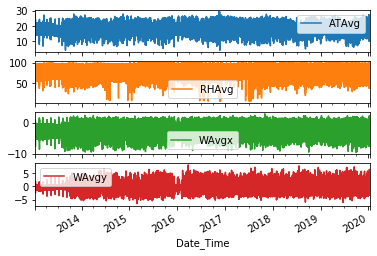

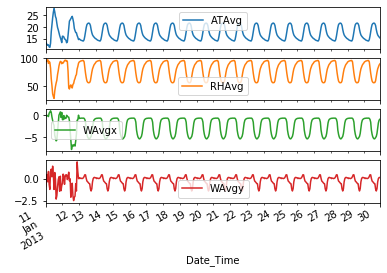

In [9]:
plot_cols = ['ATAvg', 'RHAvg', 'WAvgx','WAvgy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATAvg,61405.0,1.694126e+01,3.385494,4.190000,14.530000,1.618600e+01,19.370000,29.310000
ATMax,61405.0,1.705264e+01,3.248350,5.160000,14.600000,1.622000e+01,19.720000,29.670000
ATMin,61405.0,1.688573e+01,3.159448,4.920000,14.520000,1.611000e+01,19.470000,29.030000
RHAvg,61405.0,7.972151e+01,16.536240,5.120000,65.510000,8.379000e+01,94.980000,100.070000
RHMin,61405.0,7.910131e+01,16.940392,5.690000,62.770000,8.385000e+01,95.200000,100.050000
RHMax,61405.0,8.043544e+01,16.168787,5.700000,65.050000,8.537000e+01,95.600000,100.090000
PAvg,61405.0,5.250550e-03,0.043080,0.000000,0.000000,0.000000e+00,0.000000,5.600000
WDAvg,61405.0,1.740801e+02,58.407140,0.130000,151.580000,1.796550e+02,199.500000,354.330000
WSAvg,61405.0,2.464626e+00,2.110336,0.000000,0.680000,1.525000e+00,4.340000,9.950000
WAvgx,61405.0,-2.055486e+00,2.165681,-9.574509,-4.014477,-1.236939e+00,-0.198715,2.777757


In [11]:
### Remove PAvg and WMaxx, WMiny, WDAvg and WSAvg
df = df[['ATAvg','ATMax','ATMin',
         'RHAvg','RHMin','RHMax',
         'WAvgx','WAvgy', 'WMinx', 'WMiny',
         'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]

In [12]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

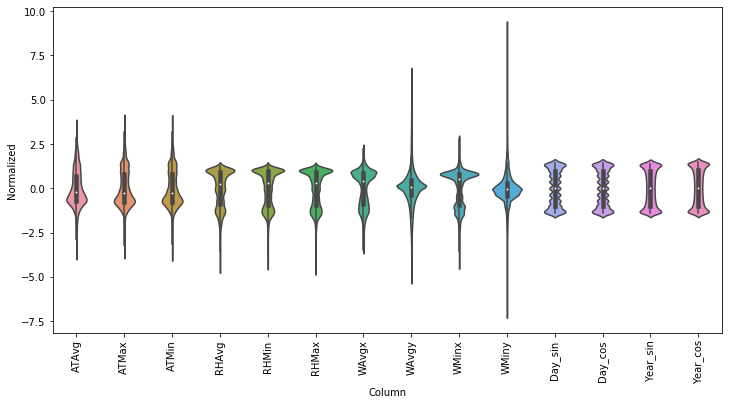

In [14]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [15]:
#### Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
### Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
#### Create sequence of arrays of all the dataset
def dataset_stack(train_df, window):
    stack = []
    for i in range(0,len(train_df[0::window])):
        start_array = window*i
        end_array = window*i + window
        if len(train_df[start_array:end_array]) < window:
            continue
        else:
            stack.append(np.array(train_df[start_array:end_array]))
    return stack
#stack = dataset_stack()

In [18]:
def plot(self, model=None, plot_col='ATAvg', max_subplots=5):
    inputs, labels = self.example
    plt.figure(figsize=(10, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            if self.label_width == 1:
                plt.scatter(self.label_indices, predictions[0, -1, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            else:
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
            
        plt.xlabel('Time [steps]')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)

  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
def compile_and_fit(model, window,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

  return history

In [22]:
def get_predictions(self, model = None, plot_col = ['ATAvg','RHAvg'], plot=True):
    
    
    plot_col_index_0 = self.column_indices[plot_col[0]]
    plot_col_index_1 = self.column_indices[plot_col[1]]
    all_preds_0=[]
    all_labels_0 =[]
    all_preds_1=[]
    all_labels_1 =[]
    
    n_batches = len(tuple(self.test))
    if self.shift==1:
        for i in range(n_batches):
            for inputs, labels in self.test.take(i):  # iterate over batches
            
                numpy_labels = labels.numpy() ### get labels
                numpy_inputs = inputs.numpy() ### get inputs
                preds = model(numpy_inputs) ### make prediction from trined model
                numpy_preds = preds.numpy() ### get predictions
                
                batch_pred_0 =numpy_preds[:,-1,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                batch_label_0 = numpy_labels[:,-1,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                batch_pred_1 =numpy_preds[:,-1,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
                batch_label_1 = numpy_labels[:,-1,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
        
                all_preds_0.extend(batch_pred_0)
                all_labels_0.extend(batch_label_0)
                all_preds_1.extend(batch_pred_1)
                all_labels_1.extend(batch_label_1)
                
        r2_0=round(r2_score(all_labels_0, all_preds_0),3)
        r2_1=round(r2_score(all_labels_1, all_preds_1),3)
        mae_0 = mean_absolute_error(all_labels_0, all_preds_0)
        mae_1 = mean_absolute_error(all_labels_1, all_preds_1)
                
        accuracy = {'r2':{plot_col[0]:r2_0,plot_col[1]:r2_1},
                            'mae':{plot_col[0]:mae_0,plot_col[1]:mae_1}}

        if plot:
            ## var 0 (ATAvg)
            slope, intercept, r_value_0, p_value, std_err = stats.linregress(all_labels_0, all_preds_0)
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].scatter(all_labels_0, all_preds_0,edgecolors='k', c='#ff5555', s=32)
            ax[0].set_xlabel(f'True Values {plot_col[0]} [de-normed]')
            ax[0].set_ylabel(f'Predicted Values {plot_col[0]} [de-normed]')
            lims = [math.floor(min(all_labels_0)-min(all_labels_0)*0.1), math.ceil(max(all_labels_0)+max(all_labels_0)*0.1)]
            ax[0].set_xlim(lims)
            ax[0].set_ylim(lims)
            line = slope*np.array(all_labels_0)+intercept
            ax[0].plot(all_labels_0, line, 'gray',label = f'r2 = {round(r_value_0**2,3)}')
            ax[0].legend(loc = 'lower right')

            ## var 1 (RHvg)
            slope, intercept, r_value_1, p_value, std_err = stats.linregress(all_labels_1, all_preds_1)
            ax[1].scatter(all_labels_1, all_preds_1,edgecolors='k', c='#0ca4b4', s=32)
            ax[1].set_xlabel(f'True Values {plot_col[1]} [de-normed]')
            ax[1].set_ylabel(f'Predicted Values {plot_col[1]} [de-normed]')
            lims = [math.floor(min(all_labels_1)-min(all_labels_1)*0.1), math.ceil(max(all_labels_1)+max(all_labels_1)*0.1)]
            ax[1].set_xlim(lims)
            ax[1].set_ylim(lims)
            line = slope*np.array(all_labels_1)+intercept
            ax[1].plot(all_labels_1, line, 'gray',label = f'r2 = {round(r_value_1**2,3)}')
            ax[1].legend(loc = 'lower right')

    else:
        for i in range(n_batches):
            #print(f'i = {i}')
            for inputs, labels in self.test.take(i):  # iterate over batches
                
                numpy_labels = labels.numpy() ### get labels
                numpy_inputs = inputs.numpy() ### get inputs
                preds = model(numpy_inputs) ### make prediction from trined model
                numpy_preds = preds.numpy() ### get predictions
                
                all_preds_by_time_0 = []
                all_labels_by_time_0 = []
                all_preds_by_time_1 = []
                all_labels_by_time_1 = []
                
                for j in range(numpy_labels.shape[1]): ## number of time steps
                    ### get values for each bacth and time and de-normalize
                    #print(f'j = {j}')
                    batch_pred_0 =numpy_preds[:,j,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                    batch_label_0 = numpy_labels[:,j,plot_col_index_0]*train_std[plot_col_index_0] + train_mean[plot_col_index_0]
                    batch_pred_1 =numpy_preds[:,j,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
                    batch_label_1 = numpy_labels[:,j,plot_col_index_1]*train_std[plot_col_index_1] + train_mean[plot_col_index_1]
        
                    all_preds_by_time_0.extend(batch_pred_0)
                    #print(f'all_preds_by_time = {len(all_preds_by_time_0)}')
                    all_labels_by_time_0.extend(batch_label_0)
                    all_preds_by_time_1.extend(batch_pred_1)
                    all_labels_by_time_1.extend(batch_label_1)
                
            
                all_preds_0.append(all_preds_by_time_0)
                all_labels_0.append(all_labels_by_time_0)
                all_preds_1.append(all_preds_by_time_1)
                all_labels_1.append(all_labels_by_time_1)
                if len(all_preds_0) >= i:
                    break
        
                ## covert to array (shape= i,time*batch_size)
        multi_preds_0 = np.vstack(all_preds_0)
        multi_labels_0 = np.vstack(all_labels_0)
        multi_preds_1 = np.vstack(all_preds_1)
        multi_labels_1 = np.vstack(all_labels_1)
        
        mae_pred = []
        r2_pred = []        
        for a in np.arange(0,multi_labels_0.shape[1],step=32):
            mae = mean_absolute_error(multi_labels_0[:,a:a+32], multi_preds_0[:,a:a+32])
            mae_pred.append(mae)
            r2 = round(r2_score(multi_labels_0[:,a:a+32], multi_preds_0[:,a:a+32]),3)
            r2_pred.append(r2)
        df = pd.DataFrame(mae_pred, columns=['mae'])
        df['r2']=r2_pred
        df['var']=plot_col[0]
        df['time']=df.index

        mae_pred = []
        r2_pred = []
        for a in np.arange(0,multi_labels_1.shape[1],step=32):
            mae = mean_absolute_error(multi_labels_1[:,a:a+32], multi_preds_1[:,a:a+32])
            mae_pred.append(mae)
            r2 = round(r2_score(multi_labels_1[:,a:a+32], multi_preds_1[:,a:a+32]),3)
            r2_pred.append(r2)
        df1 = pd.DataFrame(mae_pred, columns=['mae'])
        df1['r2']=r2_pred
        df1['var']=plot_col[1]
        df1['time']=df1.index
        df2 = df.append(df1)
        accuracy = df2.to_dict('records')  
              
        if plot:
            fig, ax = plt.subplots(2, 2, figsize=(10, 5))
            plt.suptitle(f'{model}, window: {self.input_width}_{self.shift}',fontsize = 14)
            ax[0,0].plot(df.time, df.mae, c='#ff5555')
            ax[0,0].scatter(df.time, df.mae,edgecolors='k', c='#ff5555', s=32 )
            ax[0,0].set_xlabel(f'prediction times {plot_col[0]}')
            ax[0,0].set_ylabel(f'MAE {plot_col[0]} [de-normed]')
            ax[0,1].plot(df1.time, df1.mae, c='#0ca4b4')
            ax[0,1].scatter(df1.time, df1.mae,edgecolors='k', c='#0ca4b4', s=32 )
            ax[0,1].set_xlabel(f'prediction times {plot_col[1]}')
            ax[0,1].set_ylabel(f'MAE {plot_col[1]} [de-normed]')
            ax[1,0].plot(df.time, df.r2, c='#ff5555')
            ax[1,0].scatter(df.time, df.r2,edgecolors='k', c='#ff5555', s=32 )
            ax[1,0].set_xlabel(f'prediction times {plot_col[0]}')
            ax[1,0].set_ylabel(f'R2 {plot_col[0]} [de-normed]')
            ax[1,1].plot(df1.time, df1.r2, c='#0ca4b4')
            ax[1,1].scatter(df1.time, df1.r2,edgecolors='k', c='#0ca4b4', s=32 )
            ax[1,1].set_xlabel(f'prediction times {plot_col[1]}')
            ax[1,1].set_ylabel(f'R2 {plot_col[1]} [de-normed]')
            
    return accuracy
                       
WindowGenerator.get_predictions = get_predictions

## MULTI-VARIATE + SINGLE STEP MODEL

- 24 hours prior --> predict 1 hour
- 24 hours prior --> predict 6 hours
- 48 hours prior --> predict 1 hours
- 48 hours prior --> predict 6 hours
- 48 hours prior --> predict 12 hours
- 48 hours prior --> predict 24 hours

In [23]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [24]:
def single_models(station,path,num_features,input_width, OUT_STEPS):
    ### aggragte results
    val_performance = {}
    performance = {}
    r2 ={}
    
    ## window
    window = WindowGenerator(
    input_width=input_width, label_width=1, shift=OUT_STEPS)
    window.plot()
    plt.savefig(f'{path}/{station}_{sample_freq}_w{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### Baseline
    baseline = Baseline()
    baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    val_performance[f'Baseline_{sample_freq}_w{input_width}_{OUT_STEPS}'] = baseline.evaluate(window.val)
    performance[f'Baseline_{sample_freq}_w{input_width}_{OUT_STEPS}'] = baseline.evaluate(window.test, verbose=0)
    r2[f'Baseline_{sample_freq}_w{input_width}_{OUT_STEPS}']= window.get_predictions(model=baseline,plot=False)
    #window.plot(baseline)
    #plt.savefig(f'{path}/{station}_Single_Baseline_w{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### Dense
    dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
    ])
    history = compile_and_fit(dense, window)
    IPython.display.clear_output()
    val_performance[f'Dense_{sample_freq}_w{input_width}_{OUT_STEPS}'] = dense.evaluate(window.val)
    performance[f'Dense_{sample_freq}_w{input_width}_{OUT_STEPS}'] = dense.evaluate(window.test, verbose=0)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_Single_Dense_{sample_freq}_w{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(dense)
    #plt.savefig(f'{path}/{station}_Single_Dense_w{input_width}_{OUT_STEPS}_window.png',dpi=100)
    r2[f'Dense_{sample_freq}_w{input_width}_{OUT_STEPS}']= window.get_predictions(model=dense,plot=False)
    
    #RNN
    lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
    ])
    history = compile_and_fit(lstm_model, window)
    IPython.display.clear_output()
    val_performance[f'LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}'] = lstm_model.evaluate(window.val)
    performance[f'LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}'] = lstm_model.evaluate(window.test, verbose=0)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_Single_LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(lstm_model)
    #plt.savefig(f'{path}/{station}_Single_LSTM_w{input_width}_{OUT_STEPS}_window.png',dpi=100)
    r2[f'LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}']= window.get_predictions(model=lstm_model,plot=False)
    
    ### Autoregressive RNN
    residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
    ]))

    history = compile_and_fit(residual_lstm, window)

    IPython.display.clear_output()
    val_performance[f'Residual_LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}'] = residual_lstm.evaluate(window.val)
    performance[f'Residual_LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}'] = residual_lstm.evaluate(window.test, verbose=0)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_Single_Residual_LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(lstm_model)
    #plt.savefig(f'{path}/{station}_Single_Residual_LSTM_w{input_width}_{OUT_STEPS}_window.png',dpi=100)
    plt.close()
    r2[f'Residual_LSTM_{sample_freq}_w{input_width}_{OUT_STEPS}']= window.get_predictions(model=residual_lstm,plot=False)
    

    ### Performance
    fig, ax = plt.subplots()
    x = np.arange(len(performance))
    width = 0.3
    metric_name = 'mean_absolute_error'
    metric_index = baseline.metrics_names.index('mean_absolute_error')
    val_mae = [v[metric_index] for v in val_performance.values()]
    test_mae = [v[metric_index] for v in performance.values()]

    ax.bar(x - 0.17, val_mae, width, label='Validation')
    ax.bar(x + 0.17, test_mae, width, label='Test')
    ax.set_xticks(ticks=x)
           
    ax.set_xticklabels(labels=performance.keys())
    ax.set_ylabel('MAE (average over all outputs)')
    ax.legend()
    plt.savefig(f'{path}/Performance_Single_{sample_freq}_{station}_w{input_width}_{OUT_STEPS}.png', dpi = 100,bbox_inches='tight')
    
    pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_single_{sample_freq}_w{input_width}_{OUT_STEPS}_performance_times.csv')
    pd.DataFrame.from_dict(val_performance, orient='index',columns=['loss','mae']).to_csv(f'{path}/{station}_single_{sample_freq}_w{input_width}_{OUT_STEPS}_performance_val.csv')
    pd.DataFrame.from_dict(performance, orient='index',columns=['loss','mae']).to_csv(f'{path}/{station}_single_{sample_freq}_w{input_width}_{OUT_STEPS}_performance_test.csv')
    
    return val_performance, performance, r2

## Windows

In [25]:
num_features = df.shape[1]

### 24 h + 1h

In [ ]:
input_width = 24*time_steps
OUT_STEPS = 1*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 24 h + 6h

In [ ]:
input_width = 24*time_steps
OUT_STEPS = 6*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 24 h + 24h

In [ ]:
input_width = 24*time_steps
OUT_STEPS = 24*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 6h

In [ ]:
input_width = 48*time_steps
OUT_STEPS = 6*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 12h

In [ ]:
input_width = 48*time_steps
OUT_STEPS = 12*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 24h

In [ ]:
input_width = 48*time_steps
OUT_STEPS = 24*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 48h

In [ ]:
input_width = 48*time_steps
OUT_STEPS = 48*time_steps
val_performance, performance, r2 = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

# MULTI-VARIATE + MULTI-STEP MODEL

## Windows
- 24 hours prior --> predict 1-12 hour
- 24 hours prior --> predict 1-24 hours
- 48 hours prior --> predict 1-12 hours
- 48 hours prior --> predict 1-24 hours
- 48 hours prior --> predict 1-36 hours
- 48 hours prior --> predict 1-48 hours
- 72 hours prior --> predict 1-24 hours
- 72 hours prior --> predict 1-48 hours

In [33]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


In [34]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state
FeedBack.warmup = warmup

In [35]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [38]:
def multi_models(station, path, num_features,input_width= 24, OUT_STEPS=12):
    ### aggragte results
    multi_val_performance = {}
    multi_performance = {}
    r2 ={}
    
    ## window
    window = WindowGenerator(
    input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
    window.plot()
    plt.savefig(f'{path}/{station}_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### Baseline last
    print('Baseline last')
    last_baseline = MultiStepLastBaseline()
    last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])
    multi_val_performance[f'BaselineLast_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = last_baseline.evaluate(window.val)
    multi_performance[f'BaselineLast_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = last_baseline.evaluate(window.test, verbose=0)
    r2[f'BaselineLast_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=last_baseline)
#     window.plot(last_baseline)
#     plt.savefig(f'{path}/{station}_BaselineLast_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### Baseline repeat
    if input_width == OUT_STEPS:
        print(f'Baseline repeat')
        repeat_baseline = RepeatBaseline()
        repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

        multi_val_performance[f'BaselineRepeat_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = repeat_baseline.evaluate(window.val)
        multi_performance[f'BaselineRepeat_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = repeat_baseline.evaluate(window.test, verbose=0)
        r2[f'BaselineRepeat_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=repeat_baseline)
#         window.plot(repeat_baseline)
#         plt.savefig(f'{path}/{station}_BaselineRepeat_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    else:
        print('Skipping Repeat baseline')
    
    ### Single-Shot
    print(f'Single-shot')
    multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_linear_model, window)
    IPython.display.clear_output()
    multi_val_performance[f'MultiLinear_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_linear_model.evaluate(window.val)
    multi_performance[f'MultiLinear_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_linear_model.evaluate(window.test, verbose=0)
    r2[f'MultiLinear_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=multi_linear_model)
    losses = pd.DataFrame(history.history)
    losses.plot()
    #plt.savefig(f'{path}/{station}_MultiLinear_wm{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(multi_linear_model)
    plt.savefig(f'{path}/{station}_MultiLinear_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### Dense
    print(f'Dense')
    multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_dense_model, window)
    IPython.display.clear_output()
    multi_val_performance[f'MultiDense_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_dense_model.evaluate(window.val)
    multi_performance[f'MultiDense_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_dense_model.evaluate(window.test, verbose=0)
    r2[f'MultiDense_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=multi_dense_model)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_MultiDense_{sample_freq}_wm{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(multi_dense_model)
    #plt.savefig(f'{path}/{station}_MultiDense_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### CNN
    print(f'CNN')
    CONV_WIDTH = 3
    multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_conv_model, window)
    IPython.display.clear_output()
    multi_val_performance[f'MultiConv_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_conv_model.evaluate(window.val)
    multi_performance[f'MultiConv_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_conv_model.evaluate(window.test, verbose=0)
    r2[f'MultiConv_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=multi_conv_model)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_MultiConv_{sample_freq}_wm{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(multi_conv_model)
    #plt.savefig(f'{path}/{station}_MultiConv_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### RNN
    print(f'RNN')
    multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(multi_lstm_model, window)
    IPython.display.clear_output()
    multi_val_performance[f'MultiLSTM_model_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_lstm_model.evaluate(window.val)
    multi_performance[f'MultiLSTM_model_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
    r2[f'MultiConv_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=multi_lstm_model)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_MultiLSTM_{sample_freq}_wm{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(multi_lstm_model)
    #plt.savefig(f'{path}/{station}_MultiLSTM_{sample_freq}_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    
    ### Autoregressive RNN
    print(f'Autoregressive RNN')
    feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
    prediction, state = feedback_model.warmup(window.example[0])
    history = compile_and_fit(feedback_model, window)
    IPython.display.clear_output()
    multi_val_performance[f'AR_LSTM_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = feedback_model.evaluate(window.val)
    multi_performance[f'AR_LSTM_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = feedback_model.evaluate(window.test, verbose=0)
    r2[f'AR_LSTM_{sample_freq}_wm{input_width}_{OUT_STEPS}'] = window.get_predictions(model=multi_lstm_model)
    losses = pd.DataFrame(history.history)
    losses.plot()
    plt.savefig(f'{path}/{station}_MultiAR_LSTM_{sample_freq}_wm{input_width}_{OUT_STEPS}_losses.png',dpi=100)
    #window.plot(feedback_model)
    #plt.savefig(f'{path}/{station}_MultiAR_LSTM_wm{input_width}_{OUT_STEPS}_window.png',dpi=100)
    plt.close()
    
    ### Plot Performance
    fig, ax = plt.subplots()
    x = np.arange(len(multi_performance))
    width = 0.3
    metric_name = 'mean_absolute_error'
    metric_index = last_baseline.metrics_names.index('mean_absolute_error')
    val_mae = [v[metric_index] for v in multi_val_performance.values()]
    test_mae = [v[metric_index] for v in multi_performance.values()]

    ax.bar(x - 0.17, val_mae, width, label='Validation')
    ax.bar(x + 0.17, test_mae, width, label='Test')
    ax.set_xticks(ticks=x)
           
    ax.set_xticklabels(labels=multi_performance.keys())
    ax.set_ylabel('MAE (average over all outputs)')
    ax.legend()
    plt.savefig(f'{path}/Performance_Multi_{station}_{sample_freq}_w{input_width}_{OUT_STEPS}.png', dpi = 100,bbox_inches='tight')
    
    pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_multi_{sample_freq}_wm{input_width}_{OUT_STEPS}_performance_times.csv')
    pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss','mae']).to_csv(f'{path}/{station}_multi_{sample_freq}_wm{input_width}_{OUT_STEPS}_performance_val.csv')
    pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss','mae']).to_csv(f'{path}/{station}_multi_{sample_freq}_wm{input_width}_{OUT_STEPS}_performance_test.csv')
    
    return multi_val_performance, multi_performance, r2

### 24 h + 12h

In [ ]:
input_width = 24*time_steps
OUT_STEPS =12*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width, OUT_STEPS)

### 24 h + 24h

In [ ]:
input_width = 24*time_steps
OUT_STEPS = 24*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 12h

In [ ]:
input_width = 48*time_steps
OUT_STEPS = 12*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 24h

In [ ]:
input_width = 48*time_steps
OUT_STEPS = 24*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 48h

In [ ]:
input_width = 48*time_steps
OUT_STEPS =48*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)


### 72 h + 12h

In [ ]:
input_width = 72*time_steps
OUT_STEPS = 12*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 72 h + 24h

In [ ]:
input_width = 72*time_steps
OUT_STEPS = 24*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 72 h + 48h

In [ ]:
input_width = 72*time_steps
OUT_STEPS = 48*time_steps
multi_val_performance, multi_performance, r2 = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)